# Neural Networks - Deep Learning 
## Project 2)


Ονοματεπώνυμο: Κωνσταντίνος - Ηλιας Χονδρορρίζος

In [1]:
#Importing the libraries i'm going to use
import gzip
import pickle
import time


import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
sns.set_theme(palette = "Spectral")
import keras
from keras.utils.np_utils import to_categorical 


from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.manifold import TSNE 
from sklearn.metrics import accuracy_score,classification_report,balanced_accuracy_score,average_precision_score,f1_score,confusion_matrix ,log_loss
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid 
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split

## Loading - Preprocessing

In [2]:
'''
parameters:
@file : the path where the file exists into the computer.
    Loading the data structures from the binary file.
    
return:
@dict: a dictionary with the data and the labels of each batch. 
'''
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        
    return dict

In [3]:
#load all bathches into a list.
dataBatchs = (unpickle(r'.\\cifar-10-batches-py\\data_batch_1')[b'data'],
                unpickle(r'.\\cifar-10-batches-py\data_batch_2')[b'data'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_3')[b'data'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_4')[b'data'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_5')[b'data'])
 
labels_train = (unpickle(r'.\\cifar-10-batches-py\\data_batch_1')[b'labels'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_2')[b'labels'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_3')[b'labels'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_4')[b'labels'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_5')[b'labels'])

testBatch = unpickle(r'.\\cifar-10-batches-py\\test_batch')

#concatenate the batches and flip the tuples to numpy arrays.
dataBatch = np.concatenate(dataBatchs,axis=0)
labelsBatch = np.concatenate(labels_train,axis=0)

In [4]:
scale_mapper = {0 : 'Airplane' ,1 : 'Automobile' ,2 : 'Bird',
                3 : 'Cat', 4 : 'Deer',5 : 'Dog',6 : 'Frog' ,7 : 'Horse' ,8 : 'Ship' ,9 : 'Truck'}

In [5]:
X_train = np.asarray([i for i,j in zip(dataBatch,labelsBatch) if j == 3 or j == 1])[:3000].astype("float32") / 255.0
y_train = np.asarray([j for i,j in zip(dataBatch,labelsBatch) if j == 3 or j == 1])[:3000]


X_test = np.asarray([i for i,j in zip(testBatch[b'data'],testBatch[b'labels']) if j == 3 or j == 1])[:900].astype("float32") / 255.0
y_test = np.asarray([j for i,j in zip(testBatch[b'data'],testBatch[b'labels']) if j == 3 or j == 1])[:900]

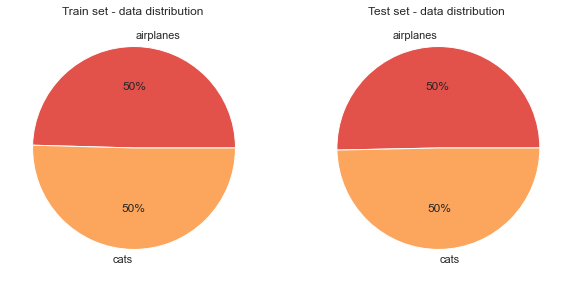

In [6]:
data_dist_train = [np.count_nonzero(y_train == 1) ,np.count_nonzero(y_train == 3)]
data_dist_test = [np.count_nonzero(y_test == 1) ,np.count_nonzero(y_test == 3)]

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,6))
axes[0].pie(data_dist_train, labels= ["airplanes","cats"], 
         autopct='%.0f%%')
axes[0].set_title("Train set - data distribution ")

axes[1].pie(data_dist_test, labels= ["airplanes","cats"], 
         autopct='%.0f%%')
axes[1].set_title("Test set - data distribution ")
plt.show()

## K-NN and Neirest Centroid

In [7]:
'''
parameters:
@f: the decorated function
    A decorator function that calculates the running time of another given function.

return:
@result: the result of the wrapped function.
@full_time: the time it took the f function to run in seconds.
'''
def timing(f):
    def wrapper(*args,**kwargs):
        start = time.time()
        result = f(*args,**kwargs)
        end = time.time()
        full_time = float(end-start)
        return result , full_time
    return wrapper

In [8]:
'''
parameters:
@neighbors: number of nearest neighbors.
    Function that initializes, runs and predicts the labels of the whole traing set using the knn algorithm.

return:
The predicted labels of the test dataset and the runnig time of the function.
'''
@timing
def knn(neighbors):
    knn = KNeighborsClassifier(n_neighbors = neighbors,weights = 'distance',n_jobs = -1)
    knn.fit(X_train,y_train)

    return knn.predict(X_test)

In [17]:
#calling the classifiers and saving their stats into accuracy_and_time array
accuracy_and_time = np.empty([0,2])

pred ,total_time = knn(1)
accuracy = float(accuracy_score(y_test,pred)*100)

accuracy_and_time = np.vstack((accuracy_and_time,[accuracy,total_time]))


pred ,total_time = knn(3)
accuracy = accuracy_score(y_test,pred)*100

accuracy_and_time = np.vstack((accuracy_and_time,[accuracy,total_time]))

In [18]:
'''
parameters:
None
    Function that initializes, runs and predicts the labels of the whole traing set using the nearest centroid algorithm.

return:
The predicted labels of the test dataset and the runnig time of the function.
'''
@timing
def Nearest_Centroid():
    nc = NearestCentroid()
    nc.fit(X_train,y_train)
    
    return nc.predict(X_test)

In [19]:
#same thing for the nearest centroid but the labels are not one hot encoded.
pred ,total_time = Nearest_Centroid()
accuracy = accuracy_score(y_test,pred)*100

accuracy_and_time=np.vstack((accuracy_and_time , [accuracy,total_time]))

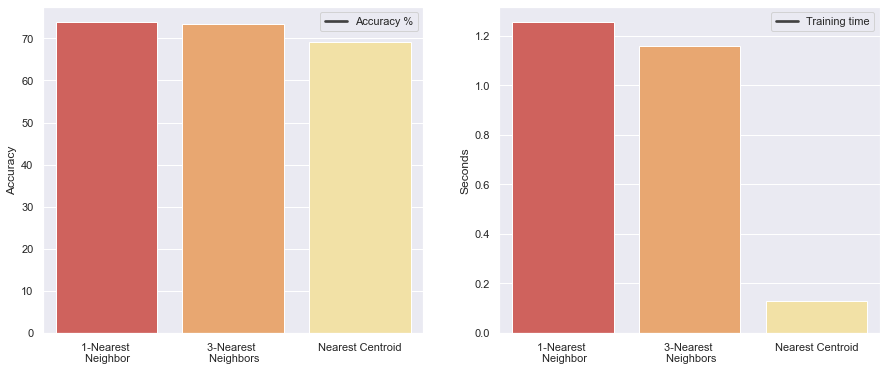

In [20]:
"""
parameters:
@listOfAlgs:A list of algorithms.
@dictionary: A dictionary containing the accuracy and training time of the algorithms in listOfAlgs.
    Generates and displays bar plots for algorithm accuracy and training time using the provided list and dictionary.
    
return:
None
"""
def BarPlots(listOfAlgs,dictionary):

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,6))

    sns.barplot(ax=axes[0],data = {"x" : listOfAlgs ,
                                   "y" : dictionary[:,0]  } ,x = "x" , y = "y")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend(["Accuracy %"])


    sns.barplot(ax =axes[1] ,data = {"x" : listOfAlgs ,
                                     "y" : dictionary[:,1] } ,x = "x" , y = "y")
    axes[1].set_ylabel("Seconds")
    axes[1].legend(["Training time"])

    plt.show()
    

BarPlots(["1-Nearest \n Neighbor","3-Nearest \n Neighbors","Nearest Centroid"],accuracy_and_time)

## Linear SVM Model

In [21]:
from sklearn.svm import SVC,LinearSVC

@timing
def Linear_SVM(images,labels,images_val):
    model = LinearSVC(C=10,max_iter=100)
    model.fit(images,labels)
    return model.predict(images_val)

pred ,total_time = Linear_SVM(X_train,y_train,X_test)
accuracy = accuracy_score(y_test,pred)*100

print("Accuracy:{}".format(accuracy))
accuracy_and_time=np.vstack((accuracy_and_time , [accuracy,total_time]))

Accuracy:77.88888888888889


C:\Users\Xrz.k\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


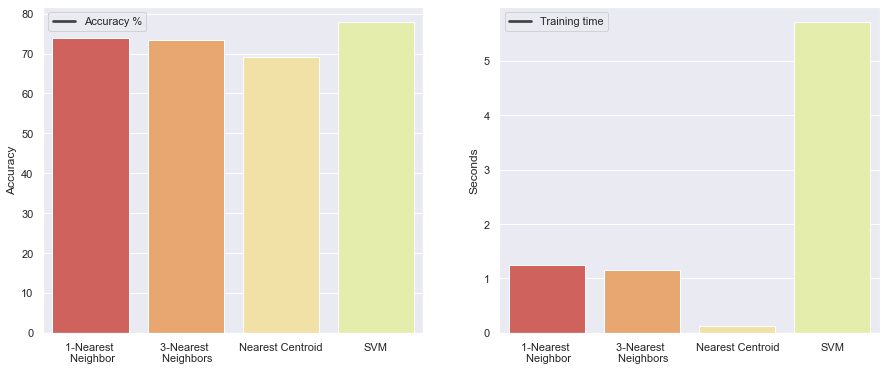

In [22]:
BarPlots(["1-Nearest \n Neighbor","3-Nearest \n Neighbors","Nearest Centroid","SVM"],accuracy_and_time)

## PCA for visualization and dataset lightening

C:\Users\Xrz.k\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Xrz.k\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


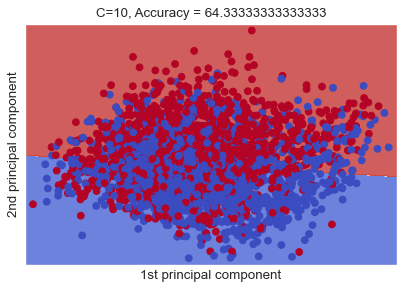

In [24]:
pca = PCA(n_components=2)
X_embedded_at2 = pca.fit_transform(X_train)

x_min, x_max = X_embedded_at2[:, 0].min() - 1, X_embedded_at2[:, 0].max() + 1
y_min, y_max = X_embedded_at2[:, 1].min() - 1, X_embedded_at2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

Z = Linear_SVM(X_embedded_at2,y_train,np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
figure(figsize=(6, 4), dpi=80)
Z = Z[0].reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X_embedded_at2[:, 0], X_embedded_at2[:, 1], c=y_train, cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("C={}, Accuracy = {}".format(10,accuracy_score(y_test,Linear_SVM(X_embedded_at2,y_train,pca.transform(X_test))[0])*100))
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.xticks(())
plt.yticks(())

plt.show()


In [25]:
#I will use 90% of datasets infomation
info = 0.90
pca = PCA(info)
pca.fit(X_train)
print("For {}% of information ,pca keeped {} principal components out of {}.".format(info*100,pca.n_components_,X_train[0].shape[0]))

For 90.0% of information ,pca keeped 98 principal components out of 3072.


C:\Users\Xrz.k\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Xrz.k\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


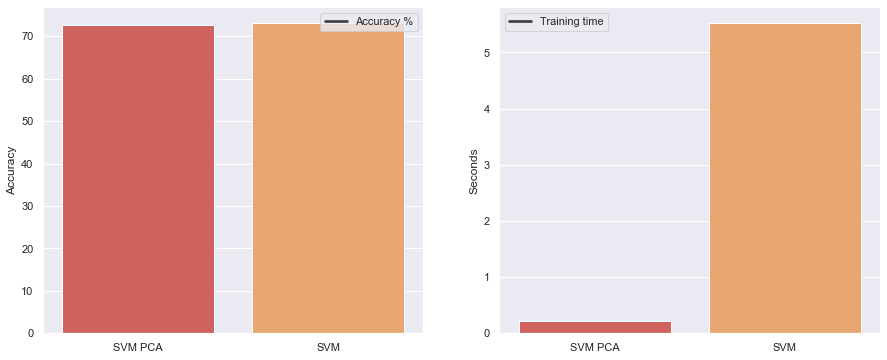

In [26]:
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

pred ,total_time = Linear_SVM(X_train_PCA,y_train,X_test_PCA)

accuracy_and_time = np.empty([0,2])

accuracy = accuracy_score(y_test,pred)*100
accuracy_and_time = np.vstack((accuracy_and_time,[accuracy,total_time]))

pred ,total_time = Linear_SVM(X_train,y_train,X_test)
accuracy = accuracy_score(y_test,pred)*100
accuracy_and_time = np.vstack((accuracy_and_time,[accuracy,total_time]))
BarPlots(["SVM PCA","SVM"],accuracy_and_time)

In [27]:
#Split the training-set (70% train / 30% validation)
from sklearn.utils import shuffle

X_train_PCA, y_train = shuffle(X_train_PCA, y_train, random_state=0)

X_train_PCA , X_val_PCA = np.split(X_train_PCA, [int(.7 * len(X_train_PCA))])
y_train_PCA , y_val_PCA = np.split(y_train, [int(.7 * len(y_train))])

## Svms models and hyper-parameter tuning

In [29]:
class MySVM:
    """
    parameters:
    @penalty: The penalty parameter of the error term.
    @Ktype: The type of kernel to use for the model. Can be 'linear', 'poly','rbf', or 'sigmoid'.
    @gamma: The gamma parameter for the model. Can be 'scale' / 'auto' or a float.
    @degree: The degree of the polynomial or sigmoid kernel.
    @coef: The coefficient of the polynomial or sigmoid kernel. Only applicable if Ktype is 'poly' or 'sigmoid'.
    @shrinking: Whether to use the shrinking heuristics for the model.
    
    Initializes the MySVM object with the given parameters.
    """
    def __init__(self ,penalty = 1.0 ,Ktype ='linear' ,gamma = 'scale' ,degree = 0, coef = 0,shrinking = True):
        
        if (Ktype == 'poly' or Ktype == "sigmoid") and degree == 0:
            self.model = SVC(C = penalty ,kernel = Ktype ,coef0 =coef ,degree = int(input(f"Give {Ktype} degree:")) ,
                             gamma = gamma ,shrinking = shrinking )
        else:
            self.model = SVC(C = penalty ,kernel = Ktype,gamma = gamma ,degree = degree ,coef0 = coef,
                             shrinking = shrinking )
   
    """
    parameters:
    @X_train: The training data.
    @y_train: The target values for the training data.

    return:
    None
    
    Fits the support vector machine model to the given training data using the 'fit' method.
    """
    @timing
    def FitData(self ,X_train ,y_train):
        self.model.fit(X_train ,y_train)
    
    """
    parameters:
    @X_test: The test data.
    @y_test: The target values for the test data.

    return:
    @accuracy: The accuracy of the model on the test data.
    @f1: he F1 score of the model on the test data.
        
    Evaluates the model's performance on the given test data using the 'predict' method and calculating the accuracy and F1 score.

    """

    def Evaluate(self, X_test ,y_test):
        pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test ,pred)*100
        f1 = f1_score(y_test , pred)*100
        return accuracy ,f1
    
    """
    parameters:
    @X: The data to make predictions on.
    @y: The true values for the data.

    return:
    None
    
    Plots and displays the model's predictions on the given data alongside the true values.
    """
    def PrintResults(self,X,y):
        fig, axes = plt.subplots(3, 5, sharex = False, figsize=(16,6))
        
        index=0
        i=0
        j=0
        predicts = self.model.predict(X)
        predicts, X, y = shuffle(predicts,X_test,y)
        for pred,true in zip(predicts,y):
            
            image = X[index].reshape(3,32,32) 
            image = image.transpose(1,2,0)
            axes[i][j].imshow(image)
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])
            
            if (true == pred):
                axes[i][j].set_title(scale_mapper[pred],color="green")
            else:
                axes[i][j].set_title(scale_mapper[pred] + f" (True:{scale_mapper[true]})  " ,color="red")
            
            
            j+=1
            if j == 5:
                i+=1
                j=0
            
            if index==14:
                break
            index+=1
        plt.show()
                           

### Kernel types.

linear kernel achived : 80.11111111111111 accuracy ,and : 79.49599083619702 f1 score
Give poly degree:4
poly kernel achived : 78.55555555555556 accuracy ,and : 75.28809218950065 f1 score
rbf kernel achived : 89.33333333333333 accuracy ,and : 88.8631090487239 f1 score
Give sigmoid degree:4
sigmoid kernel achived : 70.55555555555556 accuracy ,and : 69.71428571428572 f1 score


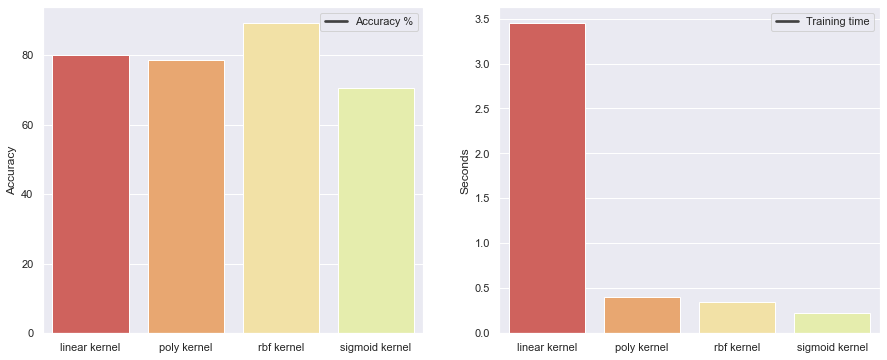

In [30]:
accuracy_and_time = np.empty([0,2])
kernels = ["linear","poly","rbf","sigmoid"]

for ker in kernels:
    model = MySVM(Ktype = ker)
    total_time = model.FitData(X_train_PCA,y_train_PCA)
    

    metrics = model.Evaluate(X_val_PCA,y_val_PCA)
    print("{} kernel achived : {} accuracy ,and : {} f1 score".format(ker,metrics[0],metrics[1]))
    
    accuracy_and_time = np.vstack((accuracy_and_time,[metrics[0],total_time[1]]))
    
BarPlots([x +" kernel" for x in kernels],accuracy_and_time)

### Polyonimal kernel (Coefficient - Degree)

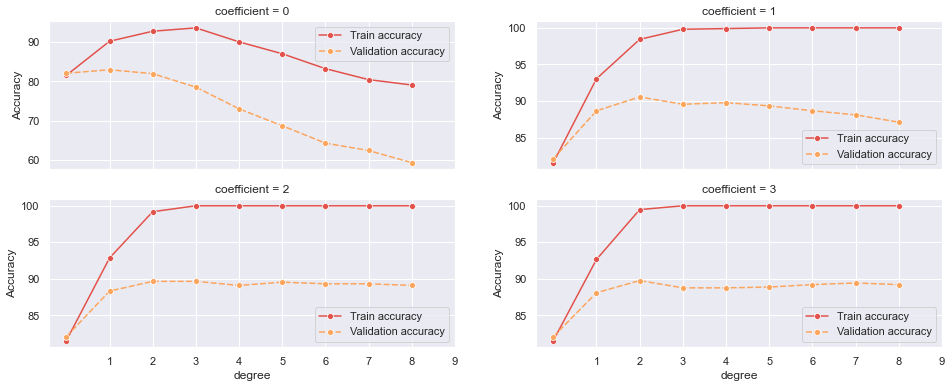

In [31]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,6))

degrees = [1,2,3,4,5,6,7,8,9]
i=0
j=0
for coef in [0,1,2,3]:
    acc_train = []
    acc_val = []
    for deg in degrees:
        
        model = MySVM(Ktype = "poly" ,degree = deg ,coef = coef )
        model.FitData(X_train_PCA,y_train_PCA)

        
        metrics = model.Evaluate(X_train_PCA,y_train_PCA)
        acc_train.append(metrics[0])
        
        metrics = model.Evaluate(X_val_PCA,y_val_PCA)
        acc_val.append(metrics[0])
        
    sns.lineplot(ax = axes[i][j], data = [acc_train,acc_val],marker = 'o')
    axes[i][j].set_title(f"coefficient = {coef}")
    axes[i][j].legend(labels=["Train accuracy","Validation accuracy",])
    axes[i][j].set_xlabel("degree")
    axes[i][j].set_ylabel("Accuracy")
    axes[i][j].set_xticks(degrees)
    
    j+=1
    if j == 2:
        i+=1
        j=0
plt.show()

### Radial Basis Function kernel (Gamma)

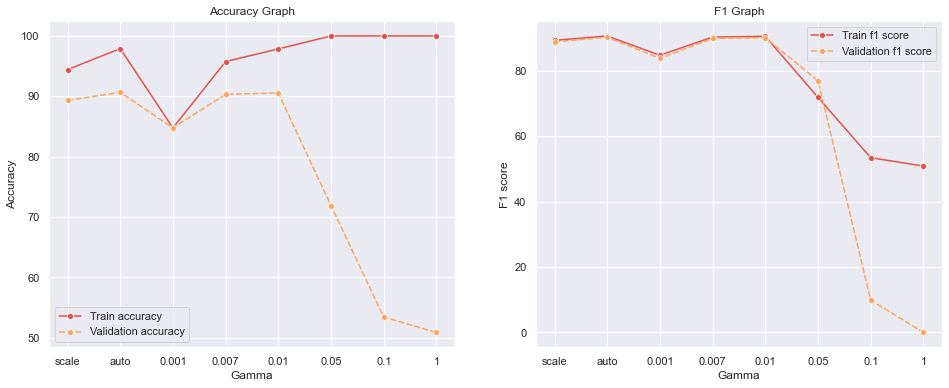

In [26]:
fig, axes = plt.subplots(1, 2, sharex = False, figsize=(16,6))

gamma = ["scale","auto",0.001,0.007,0.01,0.05,0.1,1]

acc_train = []
acc_val = []
f1_train = []
f1_val = []
for g in gamma:
    model = MySVM(Ktype = "rbf" ,gamma = g)
    model.FitData(X_train_PCA,y_train_PCA)
    
    metrics = model.Evaluate(X_train_PCA,y_train_PCA)
    acc_train.append(metrics[0])
    f1_train.append(metrics[1])
    
    metrics = model.Evaluate(X_val_PCA,y_val_PCA)
    acc_val.append(metrics[0])
    f1_val.append(metrics[1])

sns.lineplot(ax = axes[0], data = [acc_train,acc_val],marker = 'o')
axes[0].set_title("Accuracy Graph")
axes[0].legend(labels=["Train accuracy","Validation accuracy"])
axes[0].set_xlabel("Gamma")
axes[0].set_ylabel("Accuracy")
axes[0].set_xticks(range(len(gamma)),[str(x) for x in gamma])

sns.lineplot(ax = axes[1], data = [acc_val,f1_val],marker = 'o')
axes[1].set_title("F1 Graph")
axes[1].legend(labels=["Train f1 score","Validation f1 score"])
axes[1].set_xlabel("Gamma")
axes[1].set_ylabel("F1 score")
axes[1].set_xticks(range(len(gamma)),[str(x) for x in gamma])

plt.show()

### Polyonimal and RBF kernels on different C values.

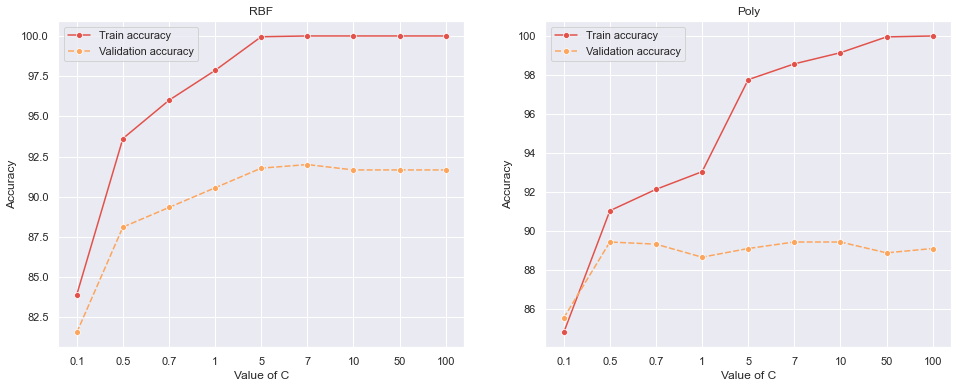

In [28]:
fig, axes = plt.subplots(1, 2, sharex = False, figsize=(16,6))

C = [0.1 , 0.5 ,0.7 ,1 ,5 ,7 ,10 ,50 ,100]
i=0
j=0
acc_train_rbf = []
acc_val_rbf = []
acc_train_poly = []
acc_val_poly = []

for c in C :
    poly_model = MySVM(Ktype = "poly" ,penalty = c , degree = 2 ,coef = 1 )
    rbf_model =  MySVM(Ktype = "rbf" ,penalty = c , gamma = 0.01 )
    
    poly_model.FitData(X_train_PCA,y_train_PCA)
    rbf_model.FitData(X_train_PCA,y_train_PCA)
    
    
    acc_train_poly.append(poly_model.Evaluate(X_train_PCA,y_train_PCA)[0])    
    acc_val_poly.append(poly_model.Evaluate(X_val_PCA,y_val_PCA)[0])
    
    acc_train_rbf.append(rbf_model.Evaluate(X_train_PCA,y_train_PCA)[0])    
    acc_val_rbf.append(rbf_model.Evaluate(X_val_PCA,y_val_PCA)[0])
    

sns.lineplot(ax = axes[0], data = [acc_train_rbf,acc_val_rbf],marker = 'o')
axes[0].set_title("RBF")
axes[0].legend(labels=["Train accuracy","Validation accuracy"])
axes[0].set_xlabel("Value of C")
axes[0].set_ylabel("Accuracy")
axes[0].set_xticks(range(len(C)),[str(x) for x in C])

sns.lineplot(ax = axes[1], data = [acc_train_poly,acc_val_poly],marker = 'o')
axes[1].set_title("Poly")
axes[1].legend(labels=["Train accuracy","Validation accuracy"])
axes[1].set_xlabel("Value of C")
axes[1].set_ylabel("Accuracy")
axes[1].set_xticks(range(len(C)),[str(x) for x in C])

plt.show()

In [32]:
rbf_model =  MySVM(Ktype = "rbf" ,penalty = 7 , gamma = 0.01 ,shrinking=False)
rbf_model.FitData(X_train_PCA,y_train_PCA)

metrics = rbf_model.Evaluate(X_test_PCA,y_test)
print(f"Accuracy :{metrics[0]}% ,F1 score:{metrics[1]}%")

Accuracy :87.44444444444444% ,F1 score:87.48615725359912%


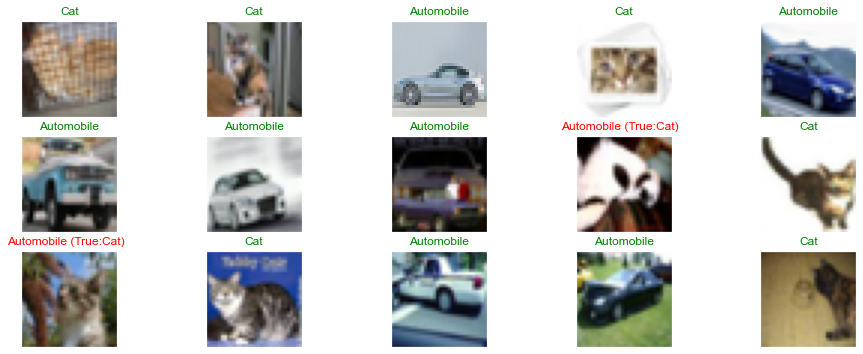

In [33]:
rbf_model.PrintResults(X_test_PCA,y_test)